# 프로젝트 개발 완료 보고서
## 미니 프로젝트 -- 도서관리 프로그램 --



개발 기간    2024.02.05 ~ 2024.02.13

개발 환경    Jupyter Notebook

개발 인원    1명 정성원

목 표<br> Oracle 데이터베이스를 사용하여 도서 및 회원, 대여정보를 저장하고 Python을 활용하여 도서관리 프로그램 구축

기 능<br> 로그인, 회원가입<br>
회원용 대여정보, 정보수정, 도서검색, 대여, 반납<br>
운영자용 도서관리, 회원관리, 대여관리

### 개발 타임라인
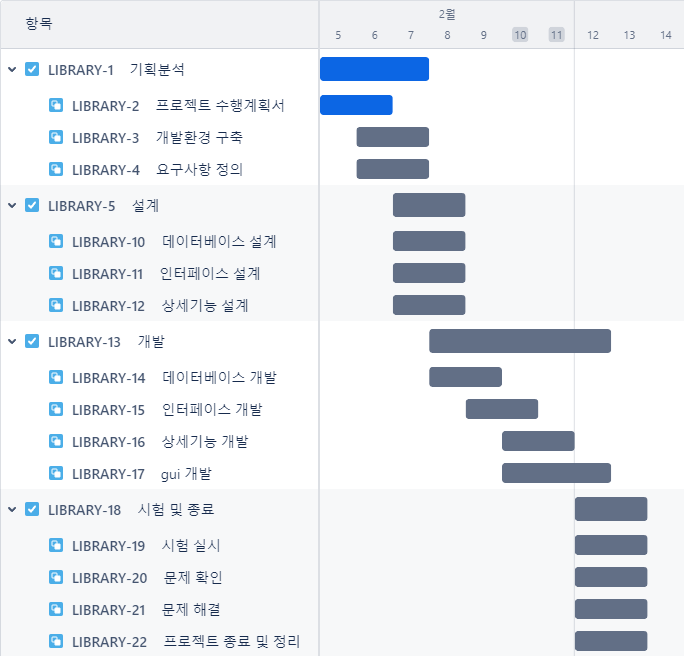

### 플로우차트
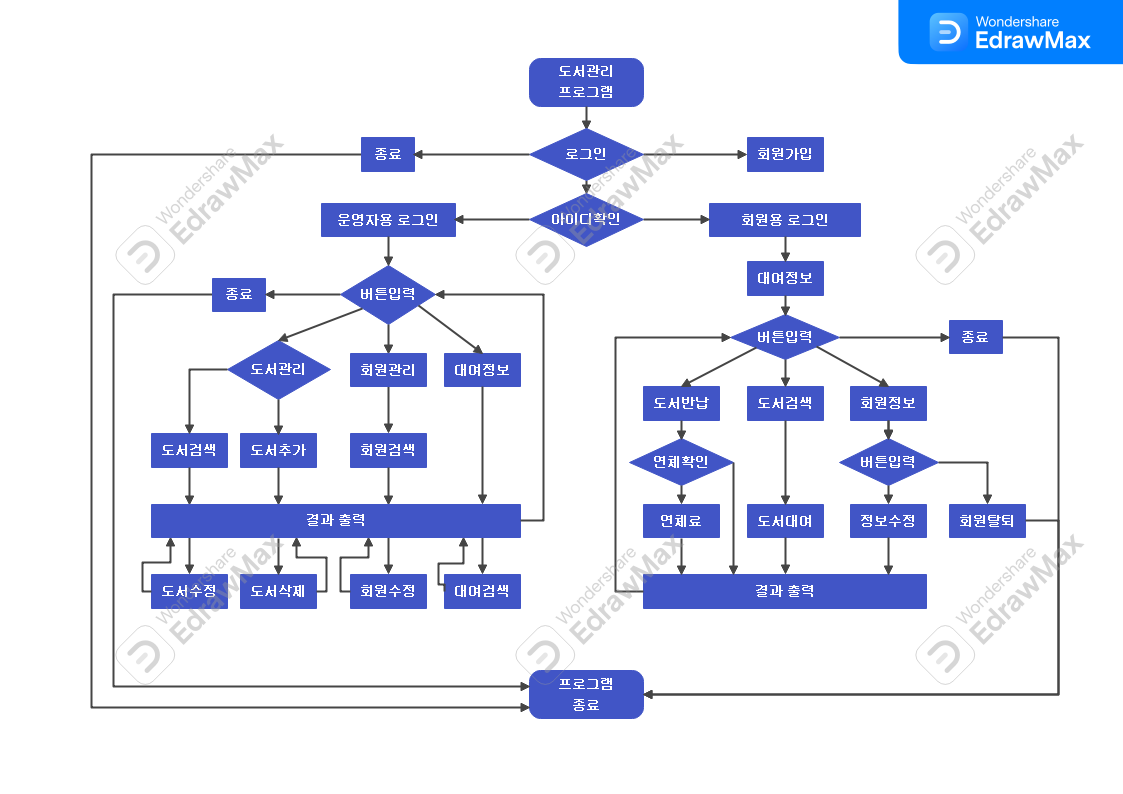

## 결과 및 향후 계획

### 결과

도서관리 프로그램으로 회원들의 정보와 도서 대여정보를 데이터베이스에 저장

대여 정보를 통해 인기있는 도서종류 등을 분석해 차후 도서 추가 시에 정보 활용 가능성

### 향후 계획

대여 정보를 오픈 데이터로 받아서 여러가지 데이터 분석해 보기

## 참고 자료
공공데이터포털

경상북도교육청 구미도서관 도서정보

## 데이터베이스
### account table
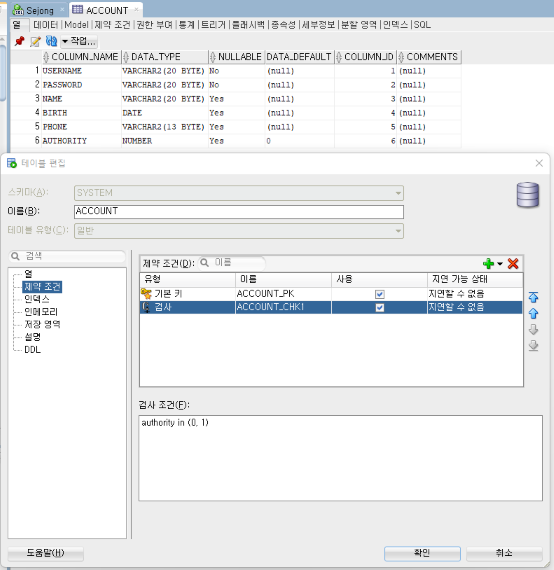

username을 primary key로 하고 authority를 check제약 조건으로 0과 1만 들어갈 수 있고 기본값으로 0을 주었습니다.

### book table
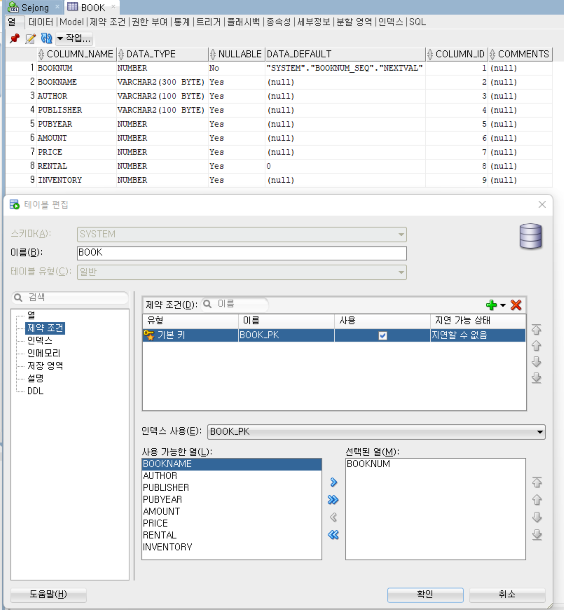

booknum를 primary key로 하고 booknum_seq라는 시퀀스를 만들어서 추가로 도서정보를 넣을 때마다 자동으로 늘어나게 했습니다.
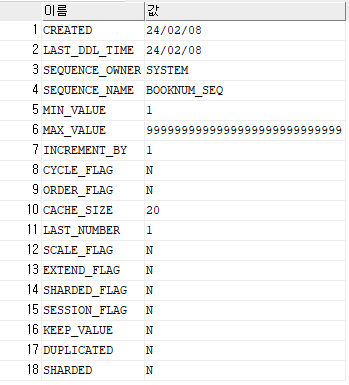

또 amount와 rental값이 변하면 자동으로 inventory값이 바뀌도록 트리거를 만들었습니다.
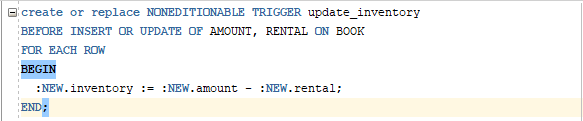

### rental table
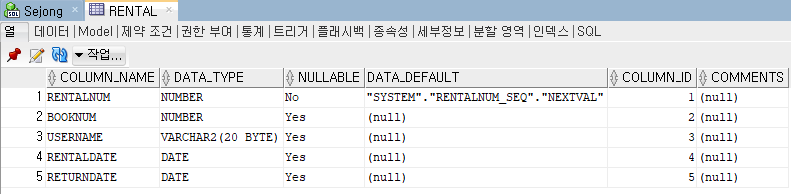

rentalnum_seq라는 시퀀스를 만들어서 대여할 때마다 자동으로 rentalnum가 증가하도록 했습니다.
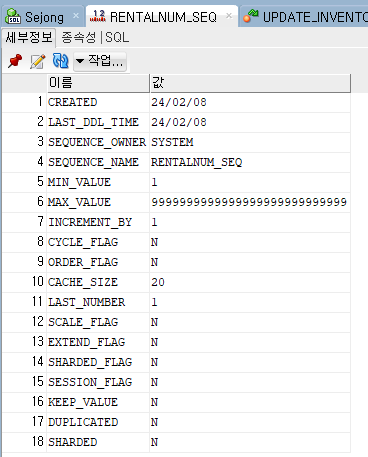

## 프로그램 코딩

In [1]:
import cx_Oracle
import tkinter as tk
from tkinter import ttk
from tkinter import messagebox, simpledialog
from datetime import datetime, timedelta

### 로그인 창
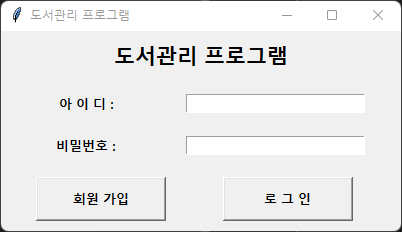

In [2]:
# 로그인 창
class LoginWindow:
    def __init__(self):
        self.cur = None
        self.run()
        
    
    def run(self):
        self.top = tk.Tk()
        self.top.title("도서관리 프로그램")
        self.top.geometry("400x200")
        self.top.columnconfigure(0, weight=1)
        self.top.columnconfigure(1, weight=1)
        self.top.rowconfigure(0, weight=1)
        
        self.main_label = tk.Label(self.top, text="도서관리 프로그램", font=("Helvetica",16,"bold"))
        self.main_label.grid(row=0, column=0, columnspan=2, sticky="nsew")
        
        self.label1 = tk.Label(self.top, text="아 이 디 : ", font=("Helvetica",10,"bold"))
        self.entry1 = tk.Entry(self.top, width=25)
        self.label1.grid(row=1, column=0, padx=10, pady=10, sticky="ew")
        self.entry1.grid(row=1, column=1, padx=10, pady=10, sticky="w")
        
        self.label2 = tk.Label(self.top, text="비밀번호 : ", font=("Helvetica",10,"bold"))
        self.entry2 = tk.Entry(self.top, show="*", width=25)
        self.label2.grid(row=2, column=0, padx=10, pady=10, sticky="ew")
        self.entry2.grid(row=2, column=1, padx=10, pady=10, sticky="w")
        
        self.new_account_button = tk.Button(self.top, width=15, height=2, text="회원 가입", font=("Helvetica",10,"bold"), command=self.new_account)
        self.new_account_button.grid(row=3, column=0, padx=10, pady=10, sticky="e")

        self.login_button = tk.Button(self.top, width=15, height=2, text="로 그 인", font=("Helvetica",10,"bold"), command=self.login)
        self.login_button.grid(row=3, column=1, padx=10, pady=10)
        
        self.top.mainloop()

        
    # Oracle DB 연결
    def db_connect(self):
        try:
            self.conn = cx_Oracle.connect('system/sejong@localhost:1521/xe')
            self.cur = self.conn.cursor()
            return self.conn
        except cx_Oracle.DatabaseError as e:
            messagebox.showerror("Database Connection Error", e)
            return None
    
    
    # 회원 가입 버튼 기능
    def new_account(self):
        if self.cur is None:
            self.db_connect()
            newAccount = NewAccount(self.top, "회원 가입", conn=self.conn, cur=self.cur)
    
    
    # 로그인 버튼 기능
    def login(self):
        if self.cur is None:
            self.db_connect()
            
        username = self.entry1.get()
        password = self.entry2.get()
        
        # 아이디, 비밀번호 입력 확인
        if not (username and password):
            messagebox.showwarning("입력 필요", "아이디와 비밀번호를 모두 입력하세요.")
            return
        
        # 아이디, 비밀번호 검증
        query = f"""select authority from account where username = '{username}' and password = '{password}'"""
        self.cur.execute(query)
        result = self.cur.fetchone()

        if result is None:
            messagebox.showerror("로그인 실패", "아이디 또는 비밀번호가 올바르지 않습니다.")
        else:
            authority = result[0]
            
            # 회원용 로그임
            if authority == 0 :
                memberWindow = MemberWindow(self.top, "회원 도서관리", username, self.conn, self.cur)
            
            # 관리자용 로그인
            else:
                managerWindow = ManagerWindow(self.top, "관리자 도서관리", username, self.conn, self.cur)


### 회원 가입 창
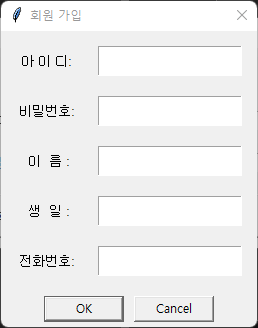

In [3]:
## 회원 가입 창
class NewAccount(simpledialog.Dialog):
    def __init__(self, parent, title, conn, cur):
        self.conn = conn
        self.cur = cur
        super().__init__(parent, title)
        
    def body(self, master):
        label_font = ("Helvetica", 10)  
        entry_font = ("Helvetica", 10)  
        
        tk.Label(master, text="아 이 디:", font=label_font).grid(row=0, column=0, padx=10, pady=10)
        tk.Label(master, text="비밀번호:", font=label_font).grid(row=1, column=0, padx=10, pady=10)
        tk.Label(master, text=" 이  름 :", font=label_font).grid(row=2, column=0, padx=10, pady=10)
        tk.Label(master, text=" 생  일 :", font=label_font).grid(row=3, column=0, padx=10, pady=10)
        tk.Label(master, text="전화번호:", font=label_font).grid(row=4, column=0, padx=10, pady=10)

        self.username_entry = tk.Entry(master, font=entry_font)
        self.password_entry = tk.Entry(master, show="*", font=entry_font)
        self.name_entry = tk.Entry(master, font=entry_font)
        self.birth_entry = tk.Entry(master, font=entry_font)
        self.phone_entry = tk.Entry(master, font=entry_font)

        self.username_entry.grid(row=0, column=1, padx=10, pady=10, ipady=5)
        self.password_entry.grid(row=1, column=1, padx=10, pady=10, ipady=5)
        self.name_entry.grid(row=2, column=1, padx=10, pady=10, ipady=5)
        self.birth_entry.grid(row=3, column=1, padx=10, pady=10, ipady=5)
        self.phone_entry.grid(row=4, column=1, padx=10, pady=10, ipady=5)
        
    def apply(self):
        username = self.username_entry.get()
        password = self.password_entry.get()
        name = self.name_entry.get()
        birth = self.birth_entry.get()
        phone = self.phone_entry.get()
        
        # 아이디 최소 길이 확인
        if len(username) < 4:
            messagebox.showerror("오류", "아이디는 최소 4자 이상이어야 합니다.")
            return

        # 비밀번호 최소 길이 확인
        if len(password) < 8:
            messagebox.showerror("오류", "비밀번호는 최소 8자 이상이어야 합니다.")
            return
        
        # 생년월일 형식 확인
        try:
            birth = datetime.datetime.strptime(birth, '%y%m%d')
        except ValueError:
            messagebox.showerror("오류", "올바른 생년월일 형식이 아닙니다. (YYMMDD)")
            return
        
        # 전화번호 형식 확인
        if not re.match(r'^\d{3}-\d{4}-\d{4}$', phone):
            messagebox.showerror("오류", "올바른 전화번호 형식이 아닙니다. (000-0000-0000)")
            return
        
        # 중복 아이디 확인
        query = f"select username from account where username = '{username}'"
        self.cur.execute(query)
        check = self.cur.fetchone()
        
        if check is not None:
            messagebox.showerror("가입 실패", "중복된 아이디입니다.")
            return
        else:
            query = f"""insert into account (username, password, name, birth, phone) 
                    values ('{username}','{password}','{name}','{birth}','{phone}')"""
            self.cur.execute(query)
            self.conn.commit()
        
        self.cur.close()
        self.conn.close()

### 회원용 창
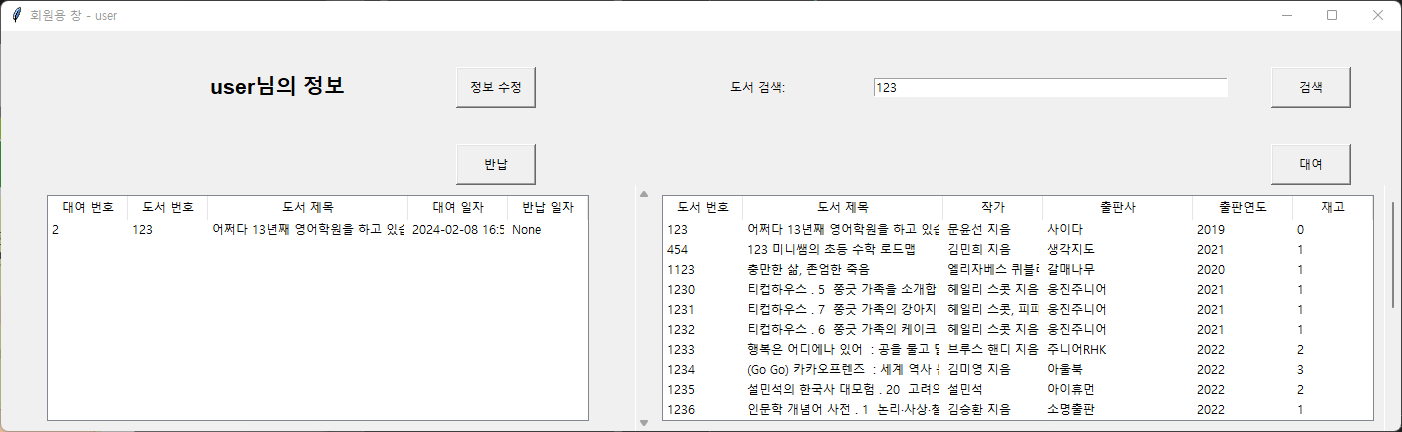

In [4]:
## 회원용 창
class MemberWindow:
    def __init__(self, parent, title, username, conn, cur):
        self.parent = parent
        self.username = username
        self.conn = conn
        self.cur = cur
        
        self.initialize_gui()

    def initialize_gui(self):
        self.top = tk.Toplevel(self.parent)
        self.top.title(f"회원용 창 - {self.username}")
        self.top.geometry("1400x400")
        self.top.columnconfigure(0, weight=1)
        self.top.columnconfigure(1, weight=1)
        self.top.rowconfigure(0, weight=1)
        
        self.main_label = tk.Label(self.top, text=f"{self.username}님의 정보", font=("Helvetica",16,"bold"))
        self.main_label.grid(row=0, column=0, padx=10, pady=10, sticky="e")
        
        # 회원 정보 버튼 생성
        self.info_button = tk.Button(self.top, width=10, height=2, text="정보 수정", command=self.update_or_delete)
        self.info_button.grid(row=0, column=1)
        
        # 대여 정보 표시를 위한 트리뷰 생성
        self.rental_treeview = ttk.Treeview(self.top, columns=("rentalnum", "r.booknum", "bookname", "rentaldate", "returndate"), show="headings")
        self.rental_treeview.heading("rentalnum", text="대여 번호")
        self.rental_treeview.column("rentalnum", width=80)
        self.rental_treeview.heading("r.booknum", text="도서 번호")
        self.rental_treeview.column("r.booknum", width=80)
        self.rental_treeview.heading("bookname", text="도서 제목")
        self.rental_treeview.column("bookname", width=200)
        self.rental_treeview.heading("rentaldate", text="대여 일자")
        self.rental_treeview.column("rentaldate", width=100)
        self.rental_treeview.heading("returndate", text="반납 일자")
        self.rental_treeview.column("returndate", width=80)
        self.rental_treeview.grid(row=2, column=0, columnspan=2, padx=10, pady=10, sticky="ns")
        
        scrollbar1 = tk.Scrollbar(self.top, orient='vertical', command=self.rental_treeview.yview)
        scrollbar1.grid(row=2, column=2, sticky="ns")
        self.rental_treeview.configure(yscrollcommand=scrollbar1.set)
        
        # 대여 정보 표시
        self.display_rental()
        
        # 반납 버튼 생성
        self.return_button = tk.Button(self.top, width=10, height=2, text="반납", command=self.return_book)
        self.return_button.grid(row=1, column=1)
        
        # 도서 검색, 대여 버튼 생성
        self.search_label = tk.Label(self.top, text="도서 검색:")
        self.search_label.grid(row=0, column=3, padx=10, pady=5, sticky="e")

        self.search_entry = tk.Entry(self.top, width=50)
        self.search_entry.grid(row=0, column=4, padx=10, pady=5, sticky="e")
        
        self.search_button = tk.Button(self.top, width=10, height=2, text="검색", command=self.search_book)
        self.search_button.grid(row=0, column=5)
        
        self.rental_button = tk.Button(self.top, width=10, height=2, text="대여", command=self.rental_book)
        self.rental_button.grid(row=1, column=5)

        # 도서 검색 결과를 표시할 트리뷰 생성
        self.search_treeview = ttk.Treeview(self.top, columns=("booknum", "bookname", "author", "publisher", "pubyear", "inventory"), show="headings")
        self.search_treeview.heading("booknum", text="도서 번호")
        self.search_treeview.column("booknum", width=80)
        self.search_treeview.heading("bookname", text="도서 제목")
        self.search_treeview.column("bookname", width=200)
        self.search_treeview.heading("author", text="작가")
        self.search_treeview.column("author", width=100)
        self.search_treeview.heading("publisher", text="출판사")
        self.search_treeview.column("publisher", width=150)
        self.search_treeview.heading("pubyear", text="출판연도")
        self.search_treeview.column("pubyear", width=100)
        self.search_treeview.heading("inventory", text="재고")
        self.search_treeview.column("inventory", width=80)
        self.search_treeview.grid(row=2, column=3, columnspan=3, padx=10, pady=10, sticky="ns")
        
        scrollbar2 = tk.Scrollbar(self.top, orient='vertical', command=self.search_treeview.yview)
        scrollbar2.grid(row=2, column=6, sticky="ns")
        self.search_treeview.configure(yscrollcommand=scrollbar2.set)
        
    # 회원 정보 수정 및 탈퇴 기능
    def update_or_delete(self):
        update_window = MemberUpdateWindow(self.top, "회원 정보 수정", self.username, self.conn, self.cur)
        
    # 대여 정보 표시 기능
    def display_rental(self):
        query = f"""
                select rentalnum, r.booknum, bookname, rentaldate, returndate from rental r, book b
                where r.booknum = b.booknum and username = '{self.username}' and returndate is null
                """
        self.cur.execute(query)
        result = self.cur.fetchall()
        
        # Treeview 위젯 내의 기존 데이터를 모두 제거
        for i in self.rental_treeview.get_children():
            self.rental_treeview.delete(i)

        # 새로 검색된 데이터를 Treeview 위젯에 추가
        for i, row in enumerate(result, start=1):
            self.rental_treeview.insert('', tk.END, values=row)
            
    # 도서 검색 기능
    def search_book(self):
        search = self.search_entry.get()
        query = f"""
                select booknum, bookname, author, publisher, pubyear, inventory from book
                where booknum like '%{search}%'
                or bookname like '%{search}%'
                or author like '%{search}%'
                or publisher like '%{search}%'
                """
        self.cur.execute(query)
        result = self.cur.fetchall()
        
        # Treeview 위젯 내의 기존 데이터를 모두 제거
        for i in self.search_treeview.get_children():
            self.search_treeview.delete(i)

        # 새로 검색된 데이터를 Treeview 위젯에 추가
        for row in result:
            self.search_treeview.insert("", tk.END, values=row)

    # 도서 대여 기능
    def rental_book(self):
        selected_item = self.search_treeview.selection()
        if not selected_item:
            messagebox.showerror("오류", "대여할 도서를 선택해주세요.")
            return
        
        # 선택된 도서의 정보를 가져옵니다.
        selected_book = self.search_treeview.item(selected_item)['values']
        booknum = selected_book[0]  # 도서 번호
        bookname = selected_book[1]  # 도서 제목

        try:
            # 재고 수량을 확인합니다.
            query = f"""
                    SELECT inventory FROM book 
                    WHERE booknum = '{booknum}'
                    """
            self.cur.execute(query)
            inventory = self.cur.fetchone()[0]

            # 재고 수량이 0보다 작으면 대여를 실패합니다.
            if inventory <= 0:
                messagebox.showerror("오류", f"{bookname} 도서는 재고가 없어 대여할 수 없습니다.")
                return
            
            # rental 테이블에 도서 대여 정보를 추가합니다.
            query = f"""
                    INSERT INTO rental (booknum, username, rentaldate) 
                    VALUES ('{booknum}', '{self.username}', SYSDATE)
                    """ 
            self.cur.execute(query)
            
            # book 테이블에서 대여 정보를 업데이트합니다.
            query = f"""
                    UPDATE book 
                    SET rental = rental + 1
                    WHERE booknum = '{booknum}'
                    """
            self.cur.execute(query)

            self.conn.commit()
            messagebox.showinfo("성공", f"{bookname} 도서를 대여했습니다.")

            # 대여 성공 후 대여 정보를 업데이트합니다.
            self.display_rental()
            
            # 검색 정보의 재고량을 업데이트합니다.
            self.search_book()

        except Exception as e:
            messagebox.showerror("오류", f"도서 대여에 실패했습니다: {str(e)}")
            
    # 도서 반납 기능
    def return_book(self):
        selected_item = self.rental_treeview.selection()
        if not selected_item:
            messagebox.showerror("오류", "반납할 도서를 선택해주세요.")
            return
        
        try:
            # 선택된 도서의 정보 가져오기
            selected_book = self.rental_treeview.item(selected_item)['values']
            rentalnum = selected_book[0]  # 대여 번호
            booknum = selected_book[1]  # 도서 번호
            bookname = selected_book[2]  # 도서 제목
            
            # 현재 시간
            current_date = datetime.now()
            
            # 대여일로부터 7일이 지났는지 확인
            query = f"""
                    SELECT rentaldate FROM rental
                    WHERE rentalnum = '{rentalnum}'
                    """
            self.cur.execute(query)
            rental_date = self.cur.fetchone()[0]

            # 대여일로부터 7일 후의 날짜 계산
            due_date = rental_date + timedelta(days=7)

            if current_date > due_date:
                # 연체료 계산 및 알림 표시
                overdue_days = (current_date - due_date).days
                overdue_fee = overdue_days * 1000  # 하루당 연체료는 1000원으로 가정
                messagebox.showwarning("알림", f"{bookname} 도서는 이미 반납 기한을 넘겼습니다. 연체료 {overdue_fee}원을 내셔야 합니다.")

                # 반납 처리를 계속할지 여부 확인
                if not messagebox.askyesno("알림", "연체료를 지불하고 계속 반납하시겠습니까?"):
                    return
            else:
                # 대여 기간이 아직 남은 경우에는 바로 반납 처리
                pass
            
            # rental 테이블에 반납 정보 추가
            query = f"""
                    UPDATE rental 
                    SET returndate = SYSDATE
                    WHERE rentalnum = '{rentalnum}'
                    """
            self.cur.execute(query)

            # book 테이블에서 해당 도서의 대여 및 재고 정보 수정
            query = f"""
                    UPDATE book
                    SET rental = rental - 1
                    WHERE booknum = '{booknum}'
                    """
            self.cur.execute(query)

            self.conn.commit()
            messagebox.showinfo("성공", f"{bookname} 도서를 반납했습니다.")

            # 반납 성공 후 대여 정보를 업데이트합니다.
            self.display_rental()
            
            # 검색 정보의 재고량을 업데이트합니다.
            self.search_book()

        except Exception as e:
            messagebox.showerror("오류", f"도서 반납에 실패했습니다: {str(e)}")


### 회원 정보 수정 및 탈퇴 창
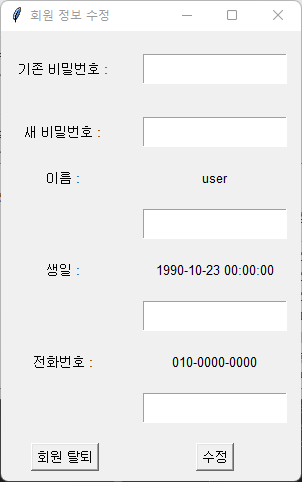

In [5]:
### 회원 정보 수정 및 탈퇴 창
class MemberUpdateWindow:
    def __init__(self, parent, title, username, conn, cur):
        self.parent = parent
        self.username = username
        self.conn = conn
        self.cur = cur
        
        # 사용자 정보 가져오기
        self.get_user_info()
        
        self.initialize_gui()

    
    def initialize_gui(self):
        self.top = tk.Toplevel(self.parent)
        self.top.title("회원 정보 수정")
        self.top.geometry("300x450")
        self.top.columnconfigure(0, weight=1)
        self.top.columnconfigure(1, weight=1)
        self.top.rowconfigure(0, weight=1)
        
        # 폰트 설정
        label_font = ("Helvetica", 10)  
        entry_font = ("Helvetica", 10)  

        # 기존 비밀번호 입력
        self.password_label = tk.Label(self.top, text="기존 비밀번호 : ", font=label_font)
        self.password_label.grid(row=0, column=0, padx=10, pady=10)
        self.password_entry = tk.Entry(self.top, show="*", font=entry_font)
        self.password_entry.grid(row=0, column=1, padx=10, pady=10, ipady=5)

        # 새 비밀번호 입력
        self.new_password_label = tk.Label(self.top, text="새 비밀번호 : ", font=label_font)
        self.new_password_label.grid(row=1, column=0, padx=10, pady=10)
        self.new_password_entry = tk.Entry(self.top, show="*", font=entry_font)
        self.new_password_entry.grid(row=1, column=1, padx=10, pady=10, ipady=5) 

        # 이름 표시 및 입력
        self.name_label1 = tk.Label(self.top, text="이름 : ", font=label_font)
        self.name_label1.grid(row=2, column=0, padx=10, pady=10)
        self.name_label2 = tk.Label(self.top, text=self.user_info[0], font=label_font)
        self.name_label2.grid(row=2, column=1, padx=10, pady=10)
        self.name_entry = tk.Entry(self.top, font=entry_font)
        self.name_entry.grid(row=3, column=1, padx=10, pady=10, ipady=5) 

        # 생일 표시 및 입력
        self.birth_label1 = tk.Label(self.top, text="생일 : ", font=label_font)
        self.birth_label1.grid(row=4, column=0, padx=10, pady=10)
        self.birth_label2 = tk.Label(self.top, text=self.user_info[1], font=label_font)
        self.birth_label2.grid(row=4, column=1, padx=10, pady=10)
        self.birth_entry = tk.Entry(self.top, font=entry_font)
        self.birth_entry.grid(row=5, column=1, padx=10, pady=10, ipady=5) 

        # 전화번호 표시 및 입력
        self.phone_label1 = tk.Label(self.top, text="전화번호 : ", font=label_font)
        self.phone_label1.grid(row=6, column=0, padx=10, pady=10)
        self.phone_label2 = tk.Label(self.top, text=self.user_info[2], font=label_font) 
        self.phone_label2.grid(row=6, column=1, padx=10, pady=10)
        self.phone_entry = tk.Entry(self.top, font=entry_font)
        self.phone_entry.grid(row=7, column=1, padx=10, pady=10, ipady=5) 

        # 수정 버튼
        self.update_button = tk.Button(self.top, text="수정", command=self.update_info, font=label_font)
        self.update_button.grid(row=8, column=1, padx=10, pady=10)

        # 회원 탈퇴 버튼
        self.delete_button = tk.Button(self.top, text="회원 탈퇴", command=self.delete_member, font=label_font)
        self.delete_button.grid(row=8, column=0, padx=10, pady=10)

        
    def get_user_info(self):
        # 사용자 정보 가져오기
        query = f"""
                SELECT name, birth, phone FROM account
                WHERE username = '{self.username}'
                """
        self.cur.execute(query)
        self.user_info = self.cur.fetchone()
    
    
    def update_info(self):
        # 수정 버튼 동작
        password = self.password_entry.get()
        new_password = self.new_password_entry.get()
        name = self.name_entry.get()
        birth = self.birth_entry.get()
        phone = self.phone_entry.get()
        
        # 기존 비밀번호 확인
        if not self.check_password(password):
            messagebox.showerror("오류", "기존 비밀번호가 일치하지 않습니다.")
            return
        
        # 비밀번호가 입력되었는지 확인
        if not new_password:
            new_password = password  # 새 비밀번호가 입력되지 않은 경우 기존 비밀번호 유지
        
        # 새 비밀번호가 8자리 이상인지 확인
        if len(new_password) < 8:
            messagebox.showerror("오류", "새 비밀번호는 8자리 이상이어야 합니다.")
            return
        
        # 입력된 정보가 있는지 확인하여 업데이트
        if name:
            self.update_field("name", name)
        if birth:
            self.update_field("birth", birth)
        if phone:
            self.update_field("phone", phone)
            
        # 비밀번호 수정
        if new_password != password:
            self.update_field("password", new_password)
        
        messagebox.showinfo("성공", "회원 정보가 수정되었습니다.")
        self.top.destroy()
        
        
    # 기존 비밀번호 확인
    def check_password(self, password):
        query = f"""
                SELECT password FROM account
                WHERE username = '{self.username}'
                """
        self.cur.execute(query)
        correct_password = self.cur.fetchone()[0]
        return password == correct_password
    
    
    # 해당 필드 업데이트
    def update_field(self, field, value):
        
        query = f"""
                UPDATE account
                SET {field} = '{value}'
                WHERE username = '{self.username}'
                """
        self.cur.execute(query)
        self.conn.commit()
    
    
    # 회원 탈퇴 기능
    def delete_member(self):
        password = simpledialog.askstring("비밀번호 확인", "비밀번호를 입력하세요:", show="*")
        if not password:
            return  # 비밀번호가 입력되지 않은 경우
        
        if not self.check_password(password):
            messagebox.showerror("오류", "비밀번호가 일치하지 않습니다.")
            return
        
        # 대여 기록 중 반납되지 않은 도서가 있는지 확인
        try:
            check_query = f"""
                          SELECT COUNT(*) FROM rental
                          WHERE username = '{self.username}' AND returndate IS NULL
                          """
            self.cur.execute(check_query)
            count = self.cur.fetchone()[0]

            if count > 0:
                # 반납되지 않은 도서가 있는 경우
                messagebox.showerror("오류", "아직 반납되지 않은 도서가 있습니다. 도서를 반납한 후에 탈퇴해주세요.")
                return
            else:
                # 반납되지 않은 도서가 없는 경우 회원을 탈퇴합니다.
                if messagebox.askyesno("확인", "정말로 회원을 탈퇴하시겠습니까?"):
                    try:
                        delete_query = f"""
                                       DELETE FROM account
                                       WHERE username = '{self.username}'
                                       """
                        self.cur.execute(delete_query)
                        self.conn.commit()
                        messagebox.showinfo("성공", "회원 탈퇴가 완료되었습니다.")
                        self.top.destroy()
                    except Exception as e:
                        messagebox.showerror("오류", f"회원 탈퇴에 실패했습니다: {str(e)}")
        except Exception as e:
            messagebox.showerror("오류", f"회원 탈퇴 확인 중 오류가 발생했습니다: {str(e)}")


### 관리자용 창
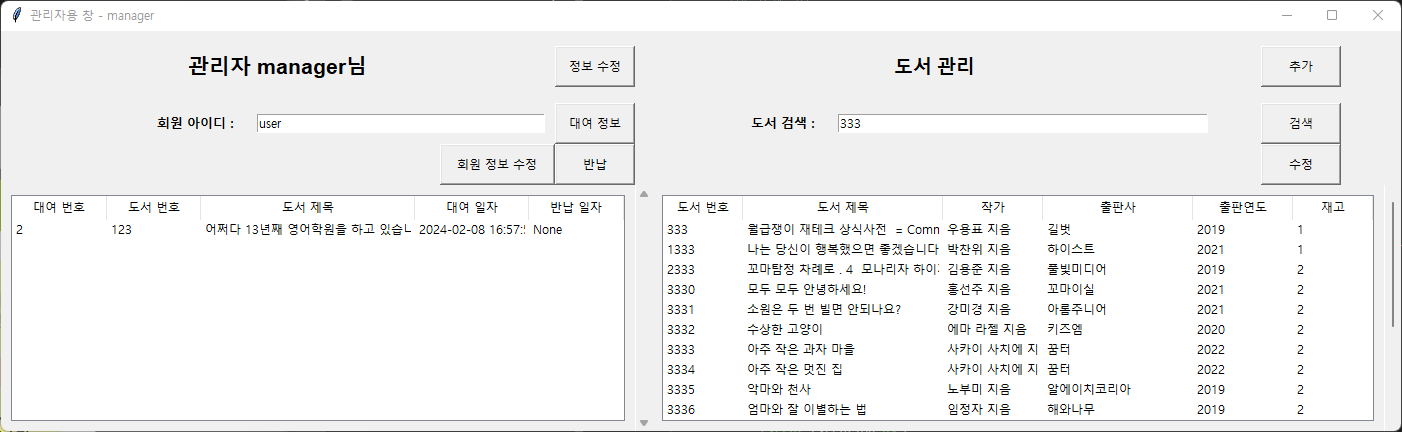

In [6]:
## 관리자용 창
class ManagerWindow:
    def __init__(self, parent, title, username, conn, cur):
        self.parent = parent
        self.username = username
        self.conn = conn
        self.cur = cur
        
        self.initialize_gui()

    
    def initialize_gui(self):
        self.top = tk.Toplevel(self.parent)
        self.top.title(f"관리자용 창 - {self.username}")
        self.top.geometry("1400x400")
        self.top.columnconfigure(0, weight=1)
        self.top.columnconfigure(1, weight=1)
        self.top.rowconfigure(0, weight=1)
        
        self.main_label = tk.Label(self.top, text=f"관리자 {self.username}님", font=("Helvetica",16,"bold"))
        self.main_label.grid(row=0, column=0, columnspan=2, padx=10, pady=10, sticky="ew")
        
        # 본인 정보 수정 버튼 생성
        self.update_info_button = tk.Button(self.top, width=10, height=2, text="정보 수정", command=self.update_info)
        self.update_info_button.grid(row=0, column=2)
        
        # 대여 정보 검색
        self.search_user_label = tk.Label(self.top, text="회원 아이디 :", font=("Helvetica",10,"bold"))
        self.search_user_label.grid(row=1, column=0, padx=10, pady=5, sticky="e")

        self.search_user_entry = tk.Entry(self.top, width=20)
        self.search_user_entry.grid(row=1, column=1, padx=10, pady=5, sticky="ew")
        
        self.search_user_rental_button = tk.Button(self.top, width=10, height=2, text="대여 정보", command=self.search_user_rental)
        self.search_user_rental_button.grid(row=1, column=2)
        
        # 회원 정보 수정 버튼 생성
        self.search_user_info_button = tk.Button(self.top, width=15, height=2, text="회원 정보 수정", command=self.search_user_info)
        self.search_user_info_button.grid(row=2, column=1, sticky="e")
       
        # 반납 버튼 생성
        self.return_book_button = tk.Button(self.top, width=10, height=2, text="반납", command=self.return_book)
        self.return_book_button.grid(row=2, column=2)

        # 대여 정보 표시를 위한 트리뷰 생성
        self.rental_treeview = ttk.Treeview(self.top, columns=("rentalnum", "r.booknum", "bookname", "rentaldate", "returndate"), show="headings")
        self.rental_treeview.heading("rentalnum", text="대여 번호")
        self.rental_treeview.column("rentalnum", width=80)
        self.rental_treeview.heading("r.booknum", text="도서 번호")
        self.rental_treeview.column("r.booknum", width=80)
        self.rental_treeview.heading("bookname", text="도서 제목")
        self.rental_treeview.column("bookname", width=200)
        self.rental_treeview.heading("rentaldate", text="대여 일자")
        self.rental_treeview.column("rentaldate", width=100)
        self.rental_treeview.heading("returndate", text="반납 일자")
        self.rental_treeview.column("returndate", width=80)
        self.rental_treeview.grid(row=3, column=0, columnspan=3, padx=10, pady=10, sticky="nsew")
        
        scrollbar1 = tk.Scrollbar(self.top, orient='vertical', command=self.rental_treeview.yview)
        scrollbar1.grid(row=3, column=3, sticky="ns")
        self.rental_treeview.configure(yscrollcommand=scrollbar1.set)
        
        # 도서 검색, 추가, 수정 버튼 생성
        self.main2_label = tk.Label(self.top, text="도서 관리", font=("Helvetica",14,"bold"))
        self.main2_label.grid(row=0, column=4, columnspan=2, padx=10, pady=10, sticky="ew")
        
        self.search_book_label = tk.Label(self.top, text="도서 검색 :", font=("Helvetica",10,"bold"))
        self.search_book_label.grid(row=1, column=4, padx=10, pady=5, sticky="e")

        self.search_book_entry = tk.Entry(self.top, width=40)
        self.search_book_entry.grid(row=1, column=5, padx=10, pady=5, sticky="ew")
        
        self.search_book_button = tk.Button(self.top, width=10, height=2, text="검색", command=self.search_book)
        self.search_book_button.grid(row=1, column=6)
        
        self.insert_book_button = tk.Button(self.top, width=10, height=2, text="추가", command=self.insert_book)
        self.insert_book_button.grid(row=0, column=6)
        
        self.update_book_button = tk.Button(self.top, width=10, height=2, text="수정", command=self.update_book)
        self.update_book_button.grid(row=2, column=6)

        # 도서 검색 결과를 표시할 트리뷰 생성
        self.search_treeview = ttk.Treeview(self.top, columns=("booknum", "bookname", "author", "publisher", "pubyear", "inventory"), show="headings")
        self.search_treeview.heading("booknum", text="도서 번호")
        self.search_treeview.column("booknum", width=80)
        self.search_treeview.heading("bookname", text="도서 제목")
        self.search_treeview.column("bookname", width=200)
        self.search_treeview.heading("author", text="작가")
        self.search_treeview.column("author", width=100)
        self.search_treeview.heading("publisher", text="출판사")
        self.search_treeview.column("publisher", width=150)
        self.search_treeview.heading("pubyear", text="출판연도")
        self.search_treeview.column("pubyear", width=100)
        self.search_treeview.heading("inventory", text="재고")
        self.search_treeview.column("inventory", width=80)
        self.search_treeview.grid(row=3, column=4, columnspan=3, padx=10, pady=10, sticky="ns")
        
        scrollbar2 = tk.Scrollbar(self.top, orient='vertical', command=self.search_treeview.yview)
        scrollbar2.grid(row=3, column=7, sticky="ns")
        self.search_treeview.configure(yscrollcommand=scrollbar2.set)

        
    # 본인 정보 수정 기능
    def update_info(self):
        update_window = MemberUpdateWindow(self.top, "정보 수정", self.username, self.conn, self.cur)
        
        
    # 대여 정보 검색 기능
    def search_user_rental(self):
        get_username = self.search_user_entry.get()
        
        query = f"""
                select rentalnum, r.booknum, bookname, rentaldate, returndate from rental r, book b
                where r.booknum = b.booknum and username = '{get_username}' and returndate is null
                """
        self.cur.execute(query)
        result = self.cur.fetchall()
        
        # Treeview 위젯 내의 기존 데이터를 모두 제거
        for i in self.rental_treeview.get_children():
            self.rental_treeview.delete(i)

        # 새로 검색된 데이터를 Treeview 위젯에 추가
        for i, row in enumerate(result, start=1):
            self.rental_treeview.insert('', tk.END, values=row)    
      
    
     # 회원 정보 수정 기능
    def search_user_info(self):
        get_username = self.search_user_entry.get()
        managerUserUpdateWindow = ManagerUserUpdateWindow(self.top, "회원 정보 수정", get_username, self.conn, self.cur)
      
        
    # 도서 반납 기능
    def return_book(self):
        selected_item = self.rental_treeview.selection()
        if not selected_item:
            messagebox.showerror("오류", "반납할 도서를 선택해주세요.")
            return
        
        try:
            # 선택된 도서의 정보 가져오기
            selected_book = self.rental_treeview.item(selected_item)['values']
            rentalnum = selected_book[0]  # 대여 번호
            booknum = selected_book[1]  # 도서 번호
            bookname = selected_book[2]  # 도서 제목
            
            # 현재 시간
            current_date = datetime.now()
            
            # 대여일로부터 7일이 지났는지 확인
            query = f"""
                    SELECT rentaldate FROM rental
                    WHERE rentalnum = '{rentalnum}'
                    """
            self.cur.execute(query)
            rental_date = self.cur.fetchone()[0]

            # 대여일로부터 7일 후의 날짜 계산
            due_date = rental_date + timedelta(days=7)

            if current_date > due_date:
                # 연체료 계산 및 알림 표시
                overdue_days = (current_date - due_date).days
                overdue_fee = overdue_days * 1000  # 하루당 연체료는 1000원으로 가정
                messagebox.showwarning("알림", f"{bookname} 도서는 이미 반납 기한을 넘겼습니다. 연체료 {overdue_fee}원을 내셔야 합니다.")

                # 반납 처리를 계속할지 여부 확인
                if not messagebox.askyesno("알림", "연체료를 지불하고 계속 반납하시겠습니까?"):
                    return
            else:
                # 대여 기간이 아직 남은 경우에는 바로 반납 처리
                pass
            
            # rental 테이블에 반납 정보 추가
            query = f"""
                    INSERT INTO rental (returndate) 
                    VALUES (SYSDATE) WHERE rentalnum = '{rentalnum}'
                    """
            self.cur.execute(query)

            # book 테이블에서 해당 도서의 대여 및 재고 정보 수정
            query = f"""
                    UPDATE book
                    SET rental = rental - 1
                    WHERE booknum = '{booknum}'
                    """
            self.cur.execute(query)

            self.conn.commit()
            messagebox.showinfo("성공", f"{bookname} 도서를 반납했습니다.")

            # 반납 성공 후 대여 정보를 업데이트합니다.
            self.search_user_rental()
            
        except Exception as e:
            messagebox.showerror("오류", f"도서 반납에 실패했습니다: {str(e)}")
    
        
    # 도서 검색 기능
    def search_book(self):
        search = self.search_book_entry.get()
        query = f"""
                select booknum, bookname, author, publisher, pubyear, inventory from book
                where booknum like '%{search}%'
                or bookname like '%{search}%'
                or author like '%{search}%'
                or publisher like '%{search}%'
                """
        self.cur.execute(query)
        result = self.cur.fetchall()
        
        # Treeview 위젯 내의 기존 데이터를 모두 제거
        for i in self.search_treeview.get_children():
            self.search_treeview.delete(i)

        # 새로 검색된 데이터를 Treeview 위젯에 추가
        for row in result:
            self.search_treeview.insert("", tk.END, values=row)

    
    # 도서 정보 추가 기능
    def insert_book(self):
        bookInsertWindow = BookInsertWindow(self.top, "도서 정보 추가", self.conn, self.cur)
    
    
    # 도서 정보 수정 기능
    def update_book(self):
        selected_item = self.search_treeview.selection()
        if not selected_item:
            messagebox.showerror("오류", "수정할 도서를 선택해주세요.")
            return
        
        selected_book = self.search_treeview.item(selected_item)['values']
        booknum = selected_book[0]  # 도서 번호
        bookUpdateWindow = BookUpdateWindow(self.top, "도서 정보 수정", booknum, self.conn, self.cur)
        
        # 수정 창이 닫힐 때 검색 기능 호출하여 검색 결과 업데이트
        self.top.wait_window(bookUpdateWindow.top)
        self.search_book()
        

### 관리자용 회원 정보 수정 창
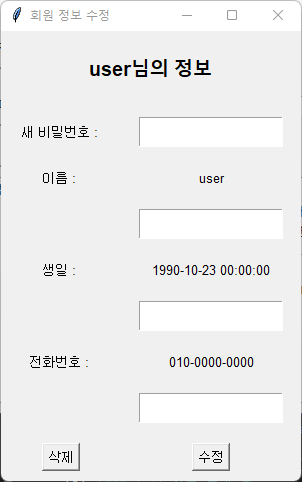

In [7]:
### 관리자용 회원 정보 수정 창
class ManagerUserUpdateWindow:
    def __init__(self, parent, title, username, conn, cur):
        self.parent = parent
        self.username = username
        self.conn = conn
        self.cur = cur
        
        # 사용자 정보 가져오기
        self.get_user_info()
        
        self.initialize_gui()

    
    def initialize_gui(self):
        self.top = tk.Toplevel(self.parent)
        self.top.title("회원 정보 수정")
        self.top.geometry("300x450")
        self.top.columnconfigure(0, weight=1)
        self.top.columnconfigure(1, weight=1)
        self.top.rowconfigure(0, weight=1)
        
        # 폰트 설정
        label_font = ("Helvetica", 10)  
        entry_font = ("Helvetica", 10)  
        
        self.main_label = tk.Label(self.top, text=f"{self.username}님의 정보", font=("Helvetica",14,"bold"))
        self.main_label.grid(row=0, column=0, columnspan=2, padx=10, pady=10, sticky="ew")

        # 새 비밀번호 입력
        self.password_label = tk.Label(self.top, text="새 비밀번호 : ", font=label_font)
        self.password_label.grid(row=1, column=0, padx=10, pady=10)
        self.password_entry = tk.Entry(self.top, show="*", font=entry_font)
        self.password_entry.grid(row=1, column=1, padx=10, pady=10, ipady=5) 

        # 이름 표시 및 입력
        self.name_label1 = tk.Label(self.top, text="이름 : ", font=label_font)
        self.name_label1.grid(row=2, column=0, padx=10, pady=10)
        self.name_label2 = tk.Label(self.top, text=self.user_info[0], font=label_font)
        self.name_label2.grid(row=2, column=1, padx=10, pady=10)
        self.name_entry = tk.Entry(self.top, font=entry_font)
        self.name_entry.grid(row=3, column=1, padx=10, pady=10, ipady=5) 

        # 생일 표시 및 입력
        self.birth_label1 = tk.Label(self.top, text="생일 : ", font=label_font)
        self.birth_label1.grid(row=4, column=0, padx=10, pady=10)
        self.birth_label2 = tk.Label(self.top, text=self.user_info[1], font=label_font)
        self.birth_label2.grid(row=4, column=1, padx=10, pady=10)
        self.birth_entry = tk.Entry(self.top, font=entry_font)
        self.birth_entry.grid(row=5, column=1, padx=10, pady=10, ipady=5) 

        # 전화번호 표시 및 입력
        self.phone_label1 = tk.Label(self.top, text="전화번호 : ", font=label_font)
        self.phone_label1.grid(row=6, column=0, padx=10, pady=10)
        self.phone_label2 = tk.Label(self.top, text=self.user_info[2], font=label_font) 
        self.phone_label2.grid(row=6, column=1, padx=10, pady=10)
        self.phone_entry = tk.Entry(self.top, font=entry_font)
        self.phone_entry.grid(row=7, column=1, padx=10, pady=10, ipady=5) 

        # 회원 정보 수정 버튼
        self.update_button = tk.Button(self.top, text="수정", command=self.update_info, font=label_font)
        self.update_button.grid(row=8, column=1, padx=10, pady=10)

        # 회원 삭제 버튼
        self.delete_button = tk.Button(self.top, text="삭제", command=self.delete_member, font=label_font)
        self.delete_button.grid(row=8, column=0, padx=10, pady=10)

        
    def get_user_info(self):
        # 회원 정보 가져오기
        query = f"""
                SELECT name, birth, phone FROM account
                WHERE username = '{self.username}'
                """
        self.cur.execute(query)
        self.user_info = self.cur.fetchone()
    
    
    def update_info(self):
        # 수정 버튼 동작
        password = self.password_entry.get()
        name = self.name_entry.get()
        birth = self.birth_entry.get()
        phone = self.phone_entry.get()
        
        # 입력된 정보가 있는지 확인하여 업데이트
        if password:
            # 새 비밀번호가 8자리 이상인지 확인
            if len(password) < 8:
                messagebox.showerror("오류", "새 비밀번호는 8자리 이상이어야 합니다.")
                return
            else:
                self.update_field("password", password)
        if name:
            self.update_field("name", name)
        if birth:
            self.update_field("birth", birth)
        if phone:
            self.update_field("phone", phone)
        
        messagebox.showinfo("성공", "회원 정보가 수정되었습니다.")
        self.top.destroy()
    
    
    # 해당 필드 업데이트
    def update_field(self, field, value):
        query = f"""
                UPDATE account
                SET {field} = '{value}'
                WHERE username = '{self.username}'
                """
        self.cur.execute(query)
        self.conn.commit()
    
    
    # 회원 삭제 기능
    def delete_member(self):     
        if messagebox.askyesno("확인", "정말로 회원을 삭제하시겠습니까?"):
            try:
                # 대여 기록 중 반납되지 않은 대여 기록이 있는지 확인하는 쿼리
                check_query = f"""
                              SELECT COUNT(*) FROM rental
                              WHERE username = '{self.username}' AND returndate IS NULL
                              """
                self.cur.execute(check_query)
                count = self.cur.fetchone()[0]

                if count > 0:
                    # 대여 기록 중 반납되지 않은 대여 기록이 있는 경우
                    messagebox.showerror("오류", "아직 반납되지 않은 도서가 있는 회원은 삭제할 수 없습니다.")
                else:
                    # 대여 기록 중 반납되지 않은 대여 기록이 없는 경우 회원을 삭제합니다.
                    delete_query = f"""
                                   DELETE FROM account
                                   WHERE username = '{self.username}'
                                   """
                    self.cur.execute(delete_query)
                    self.conn.commit()
                    messagebox.showinfo("성공", "회원이 삭제되었습니다.")
                    self.top.destroy()
            except Exception as e:
                messagebox.showerror("오류", f"회원 삭제에 실패했습니다: {str(e)}")


### 도서 정보 추가 창
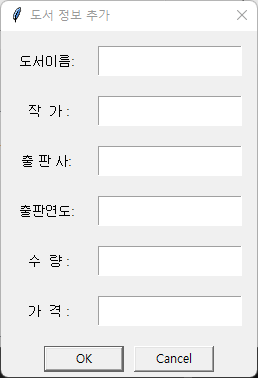

In [8]:
### 도서 정보 추가 창
class BookInsertWindow(simpledialog.Dialog):
    def __init__(self, parent, title, conn, cur):
        self.conn = conn
        self.cur = cur
        super().__init__(parent, title)
        
        
    def body(self, master):
        label_font = ("Helvetica", 10)
        entry_font = ("Helvetica", 10) 
        
        tk.Label(master, text="도서이름:", font=label_font).grid(row=0, column=0, padx=10, pady=10)
        tk.Label(master, text=" 작  가 :", font=label_font).grid(row=1, column=0, padx=10, pady=10)
        tk.Label(master, text="출 판 사:", font=label_font).grid(row=2, column=0, padx=10, pady=10)
        tk.Label(master, text="출판연도:", font=label_font).grid(row=3, column=0, padx=10, pady=10)
        tk.Label(master, text=" 수  량 :", font=label_font).grid(row=4, column=0, padx=10, pady=10)
        tk.Label(master, text=" 가  격 :", font=label_font).grid(row=5, column=0, padx=10, pady=10)

        self.bookname_entry = tk.Entry(master, font=entry_font)
        self.author_entry = tk.Entry(master, font=entry_font)
        self.publisher_entry = tk.Entry(master, font=entry_font)
        self.pubyear_entry = tk.Entry(master, font=entry_font)
        self.amount_entry = tk.Entry(master, font=entry_font)
        self.price_entry = tk.Entry(master, font=entry_font)

        self.bookname_entry.grid(row=0, column=1, padx=10, pady=10, ipady=5)
        self.author_entry.grid(row=1, column=1, padx=10, pady=10, ipady=5)
        self.publisher_entry.grid(row=2, column=1, padx=10, pady=10, ipady=5)
        self.pubyear_entry.grid(row=3, column=1, padx=10, pady=10, ipady=5)
        self.amount_entry.grid(row=4, column=1, padx=10, pady=10, ipady=5)
        self.price_entry.grid(row=5, column=1, padx=10, pady=10, ipady=5)
        
    
    def apply(self):
        bookname = self.bookname_entry.get().strip()
        author = self.author_entry.get().strip()
        publisher = self.publisher_entry.get().strip()
        pubyear = self.pubyear_entry.get().strip()
        amount = self.amount_entry.get().strip()
        price = self.price_entry.get().strip()
        
        # 빈 칸 확인
        if not bookname or not author or not publisher or not pubyear or not amount or not price:
            messagebox.showerror("추가 실패", "모든 정보를 입력해주세요.")
            return
    
        # 중복 도서 확인
        query = f"""select * from book 
                    where bookname = '{bookname}' 
                    and author = '{author}' 
                    and publisher = '{publisher}' 
                    and pubyear = '{pubyear}'
                    """
        self.cur.execute(query)
        check = self.cur.fetchone()
        
        if check is not None:
            messagebox.showerror("추가 실패", "중복된 도서입니다.")
            return
        else:
            try:
                query = f"""insert into book (bookname, author, publisher, pubyear, amount, price) 
                        values ('{bookname}','{author}','{publisher}','{pubyear}','{amount}','{price}')"""
                self.cur.execute(query)
                self.conn.commit()
                messagebox.showinfo("추가 성공", "도서 정보가 추가되었습니다.")
            except Exception as e:
                messagebox.showerror("추가 실패", f"도서 정보 추가에 실패했습니다: {str(e)}")

### 도서 정보 수정 창
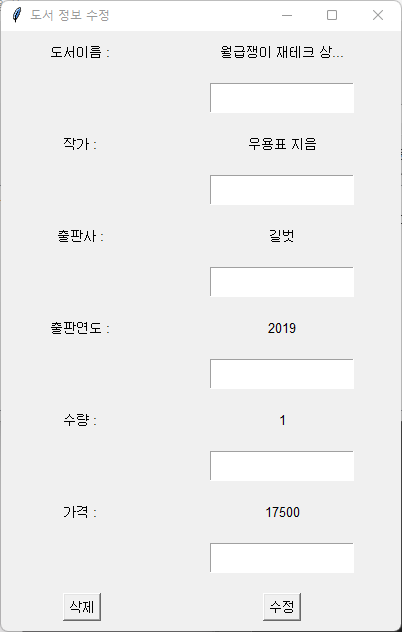

In [9]:
### 도서 정보 수정 창
class BookUpdateWindow:
    def __init__(self, parent, title, booknum, conn, cur):
        self.parent = parent
        self.booknum = booknum
        self.conn = conn
        self.cur = cur
        
        # 도서 정보 가져오기
        self.get_book_info()
        
        self.initialize_gui()

    
    def initialize_gui(self):
        self.top = tk.Toplevel(self.parent)
        self.top.title("도서 정보 수정")
        self.top.geometry("400x600")
        self.top.columnconfigure(0, weight=1)
        self.top.columnconfigure(1, weight=1)
        self.top.rowconfigure(0, weight=1)
        
        # 폰트 설정
        label_font = ("Helvetica", 10)  
        entry_font = ("Helvetica", 10)  
        
        # 도서 이름 표시 및 입력
        book_name = self.book_info[0]
        display_book_name = book_name[:10] + "..." if len(book_name) > 10 else book_name
        self.bookname_label1 = tk.Label(self.top, text="도서이름 : ", font=label_font)
        self.bookname_label1.grid(row=0, column=0, padx=10, pady=10)
        self.bookname_label2 = tk.Label(self.top, text=display_book_name, font=label_font)
        self.bookname_label2.grid(row=0, column=1, padx=10, pady=10)
        self.bookname_entry = tk.Entry(self.top, font=entry_font)
        self.bookname_entry.grid(row=1, column=1, padx=10, pady=10, ipady=5) 
        
        # 작가 표시 및 입력
        author = self.book_info[1]
        display_author = author[:10] + "..." if len(author) > 10 else author
        self.author_label1 = tk.Label(self.top, text="작가 : ", font=label_font)
        self.author_label1.grid(row=2, column=0, padx=10, pady=10)
        self.author_label2 = tk.Label(self.top, text=display_author, font=label_font)
        self.author_label2.grid(row=2, column=1, padx=10, pady=10)
        self.author_entry = tk.Entry(self.top, font=entry_font)
        self.author_entry.grid(row=3, column=1, padx=10, pady=10, ipady=5) 
        
        # 출판사 표시 및 입력
        publisher = self.book_info[2]
        display_publisher = publisher[:10] + "..." if len(publisher) > 10 else publisher
        self.publisher_label1 = tk.Label(self.top, text="출판사 : ", font=label_font)
        self.publisher_label1.grid(row=4, column=0, padx=10, pady=10)
        self.publisher_label2 = tk.Label(self.top, text=display_publisher, font=label_font)
        self.publisher_label2.grid(row=4, column=1, padx=10, pady=10)
        self.publisher_entry = tk.Entry(self.top, font=entry_font)
        self.publisher_entry.grid(row=5, column=1, padx=10, pady=10, ipady=5) 

        # 출판연도 표시 및 입력
        self.pubyear_label1 = tk.Label(self.top, text="출판연도 : ", font=label_font)
        self.pubyear_label1.grid(row=6, column=0, padx=10, pady=10)
        self.pubyear_label2 = tk.Label(self.top, text=self.book_info[3], font=label_font)
        self.pubyear_label2.grid(row=6, column=1, padx=10, pady=10)
        self.pubyear_entry = tk.Entry(self.top, font=entry_font)
        self.pubyear_entry.grid(row=7, column=1, padx=10, pady=10, ipady=5) 

        # 수량 표시 및 입력
        self.amount_label1 = tk.Label(self.top, text="수량 : ", font=label_font)
        self.amount_label1.grid(row=8, column=0, padx=10, pady=10)
        self.amount_label2 = tk.Label(self.top, text=self.book_info[4], font=label_font)
        self.amount_label2.grid(row=8, column=1, padx=10, pady=10)
        self.amount_entry = tk.Entry(self.top, font=entry_font)
        self.amount_entry.grid(row=9, column=1, padx=10, pady=10, ipady=5) 

        # 가격 표시 및 입력
        self.price_label1 = tk.Label(self.top, text="가격 : ", font=label_font)
        self.price_label1.grid(row=10, column=0, padx=10, pady=10)
        self.price_label2 = tk.Label(self.top, text=self.book_info[5], font=label_font) 
        self.price_label2.grid(row=10, column=1, padx=10, pady=10)
        self.price_entry = tk.Entry(self.top, font=entry_font)
        self.price_entry.grid(row=11, column=1, padx=10, pady=10, ipady=5) 

        # 수정 버튼
        self.update_book_button = tk.Button(self.top, text="수정", command=self.update_book, font=label_font)
        self.update_book_button.grid(row=12, column=1, padx=10, pady=10)

        # 삭제 버튼
        self.delete_book_button = tk.Button(self.top, text="삭제", command=self.delete_book, font=label_font)
        self.delete_book_button.grid(row=12, column=0, padx=10, pady=10)

        
    # 도서 정보 가져오기
    def get_book_info(self):
        query = f"""
                SELECT bookname, author, publisher, pubyear, amount, price FROM book
                WHERE booknum = '{self.booknum}'
                """
        self.cur.execute(query)
        self.book_info = self.cur.fetchone()
    
    
    # 도서 수정 기능
    def update_book(self):
        bookname = self.bookname_entry.get()
        author = self.author_entry.get()
        publisher = self.publisher_entry.get()
        pubyear = self.pubyear_entry.get()
        amount = self.amount_entry.get()
        price = self.price_entry.get()
        
        # 입력된 정보가 있는지 확인하여 업데이트
        if bookname:
            self.update_field("bookname", bookname)
        if author:
            self.update_field("author", author)
        if publisher:
            self.update_field("publisher", publisher)
        if pubyear:
            self.update_field("pubyear", pubyear)
        if amount:
            self.update_field("amount", amount)
        if price:
            self.update_field("price", price)
        
        messagebox.showinfo("성공", "도서 정보가 수정되었습니다.")
        self.top.destroy()

    
    # 해당 필드 업데이트
    def update_field(self, field, value):
        query = f"""
                UPDATE book
                SET {field} = '{value}'
                WHERE booknum = '{self.booknum}'
                """
        self.cur.execute(query)
        self.conn.commit()
    
    
    # 도서 삭제 기능
    def delete_book(self):   
        if messagebox.askyesno("확인", "정말로 도서 정보를 삭제하시겠습니까?"):
            query = f"""
                    DELETE FROM book
                    WHERE booknum = '{self.booknum}'
                    """
            self.cur.execute(query)
            self.conn.commit()
            messagebox.showinfo("성공", "도서 정보 삭제되었습니다.")
            self.top.destroy()
 

In [10]:
# 프로그램 실행하기
if __name__ == '__main__':
    LoginWindow()
